### Bước 1: Đọc dữ liệu

In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Tải dữ liệu cần thiết
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
# Đọc file CSV
file_path = r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\RawData\k-means_BBC_text_data\bbc-text.csv'
df = pd.read_csv(file_path)

# Hiển thị vài dòng đầu tiên
df.head()

### Bước 2: Tiền xử lý văn bản

In [ ]:
# Khởi tạo stopwords và lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Áp dụng hàm tiền xử lý lên cột 'text'
df['clean_text'] = df['text'].apply(preprocess_text)

df_clean = df.copy()['clean_text']
# Xem kết quả
print(df_clean.head())

df_clean.to_csv(r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\Algorithms\k-means\cleaned_text.csv', index=False)

0    tv future hand viewer home theatre system plas...
1    worldcom bos left book alone former worldcom b...
2    tiger wary farrell gamble leicester say rushed...
3    yeading face newcastle fa cup premiership side...
4    ocean twelve raid box office ocean twelve crim...
Name: clean_text, dtype: object


### Bước 3: Vector hóa văn bản bằng TF-IDF

In [12]:

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_clean)

### Bước 4: Giảm chiều dữ liệu bằng PCA

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

### Bước 5: Áp dụng K-Means++ 



In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

df_clustered = df[['category', 'clean_text']].copy()
df_clustered['Cluster'] = labels

# 9. Lưu vào file CSV
df_clustered.to_csv(r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\Algorithms\k-means\clustered_text.csv',index=False)


### Bước 6: Vẽ biểu đồ phân cụm

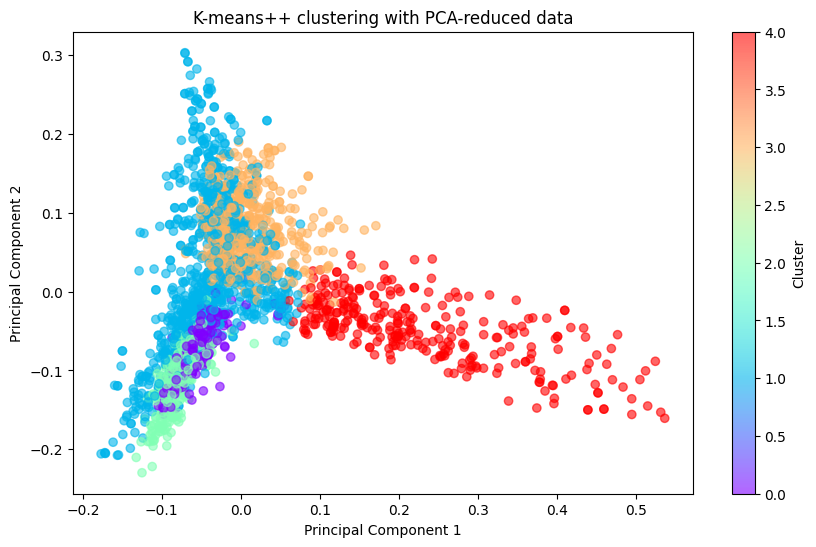

In [ ]:


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.6)
plt.title("K-means++ clustering with PCA-reduced data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()